#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import time

from catboost import CatBoostRegressor, cv, train
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

### Первичный осмотр

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Цель нашей работы создать модель которая будет предсказывать количество заказов такси на следующий час. Для этого заказчик предоставил нам данные, состоящие из 26496 строк, содержащих время (интервал равен 10 минутам) и количества заказов. По первичному взгляду на данные можно заметить что отсутствуют пропуски. Однако столбец с датой и временем имеет неверный тип данных, также его нужно проверить на хронологический порядок.

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [6]:
data['datetime'].is_monotonic

True

Тип данных исправили, порядок проверили, он присутствует. 

### Ресемплинг

Для нашей работы столбец с данными времени и даты мы сделаем индексируеющим столбцом. Но для начала изменим временной интервал с 10 минут на 1 час. Так как предсказывать модели нужно значения для следующего часа.

In [7]:
data=data.set_index('datetime')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
data = data.resample('1H').sum()
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


## Анализ

###  Визуализируем данные

<AxesSubplot:title={'center':'график данных'}, xlabel='datetime'>

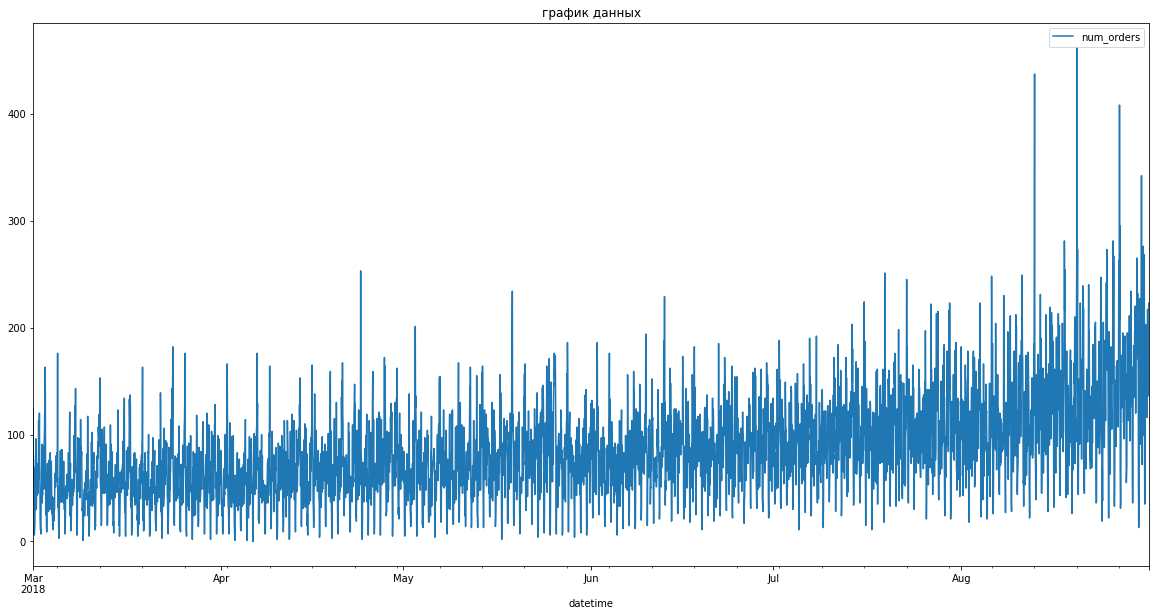

In [10]:
data.plot(figsize =(20,10), title='график данных')

Пока что график нечитабельный. Но мы можем отметить что у нас данные только за 2018 год. 

Посмотрим график за первые 10 суток. 

<AxesSubplot:title={'center':'Первые 10 суток'}, xlabel='datetime'>

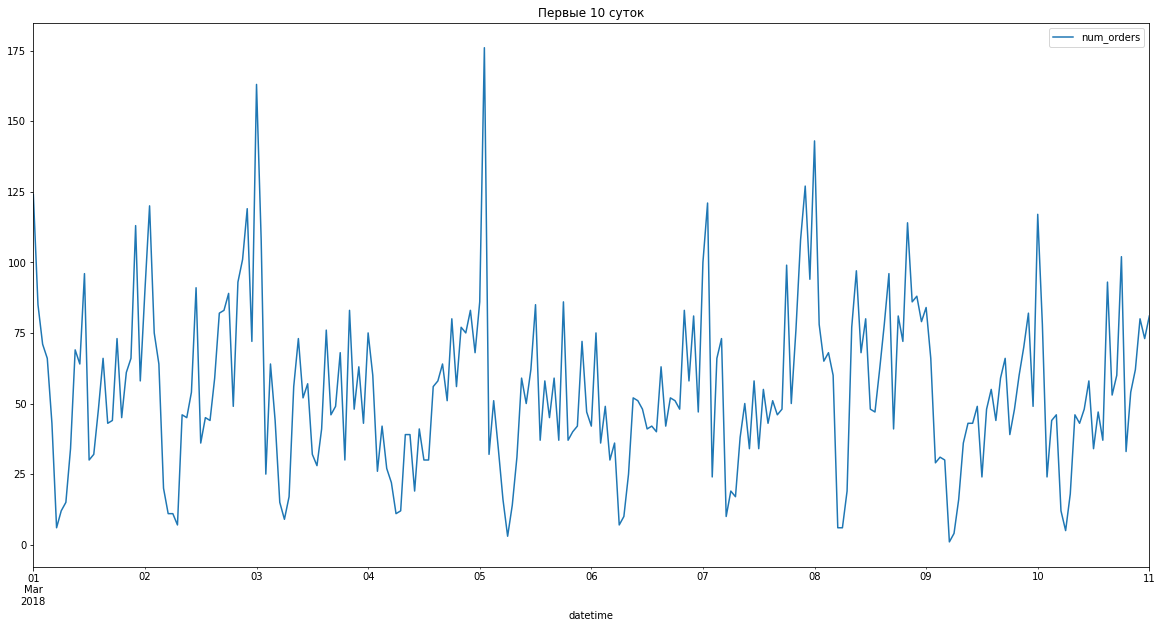

In [11]:
data[:241].plot(figsize =(20,10), title='Первые 10 суток')

Можно отметить что по большей части пиковые значения заказов достигаются на рубежах суток. А самые низкие значения происходят ранним утром. В целом это логично, поэтому возможно так устроено большинство данных, а не только первые 10 суток.

На самом первом графике можно заметить что график как-будто бы немного поднимается вверх в конце. Посмотрим так ли это с помощью скользящей средней. 

<AxesSubplot:title={'center':'график скользящей средней'}, xlabel='datetime'>

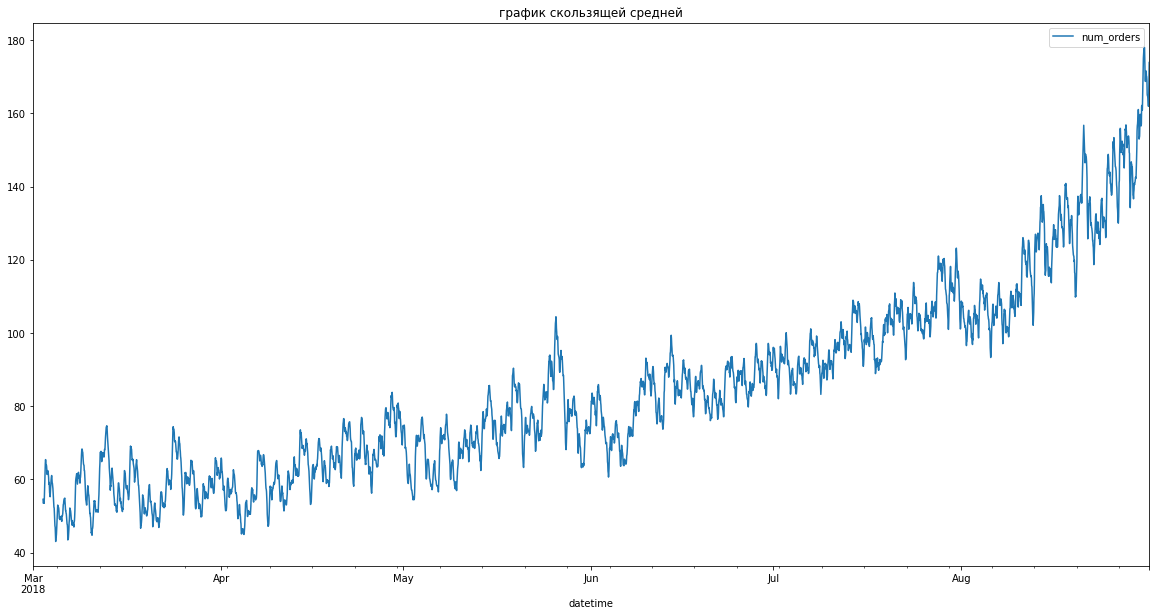

In [12]:
data.rolling(40).mean().plot(figsize =(20,10), title='график скользящей средней')

Можно утверждать что суммарно количество заказов постепенно увеличивается. Возможно фирма заказчика расширяется или увеличивается спрос на услуги такси, ну или и то и то.

### Тренд и сезонность данных

Посмотрим на тренд и сезонность данных. 

In [13]:
decomposed = seasonal_decompose(data)

<AxesSubplot:title={'center':'тренд'}, xlabel='datetime'>

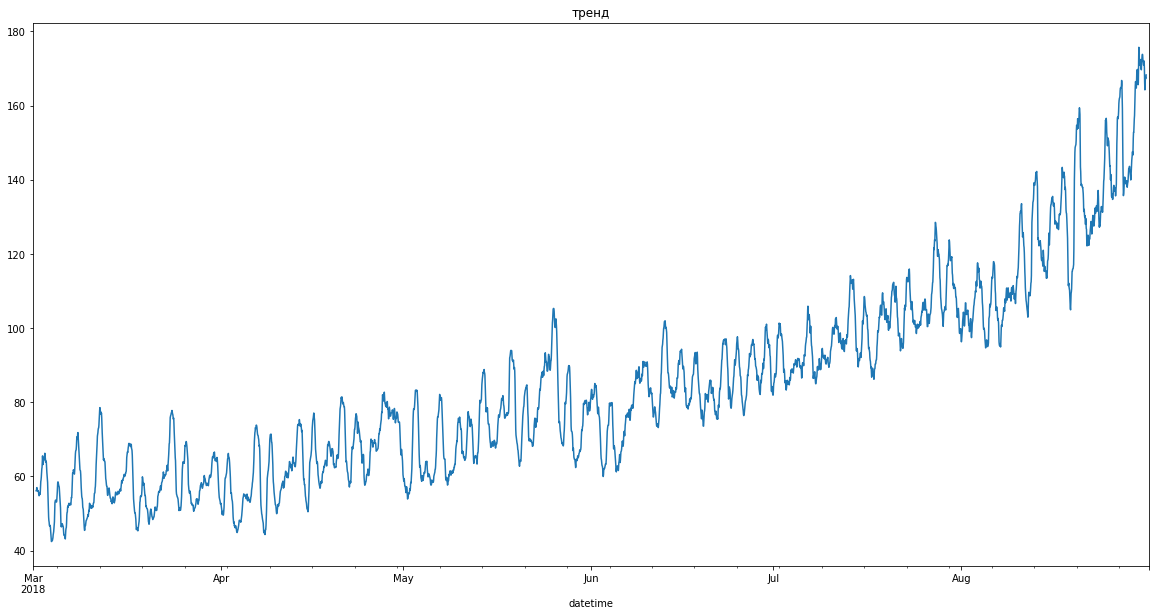

In [14]:
decomposed.trend.plot(figsize =(20,10), title='тренд')

<AxesSubplot:title={'center':'сезонность'}, xlabel='datetime'>

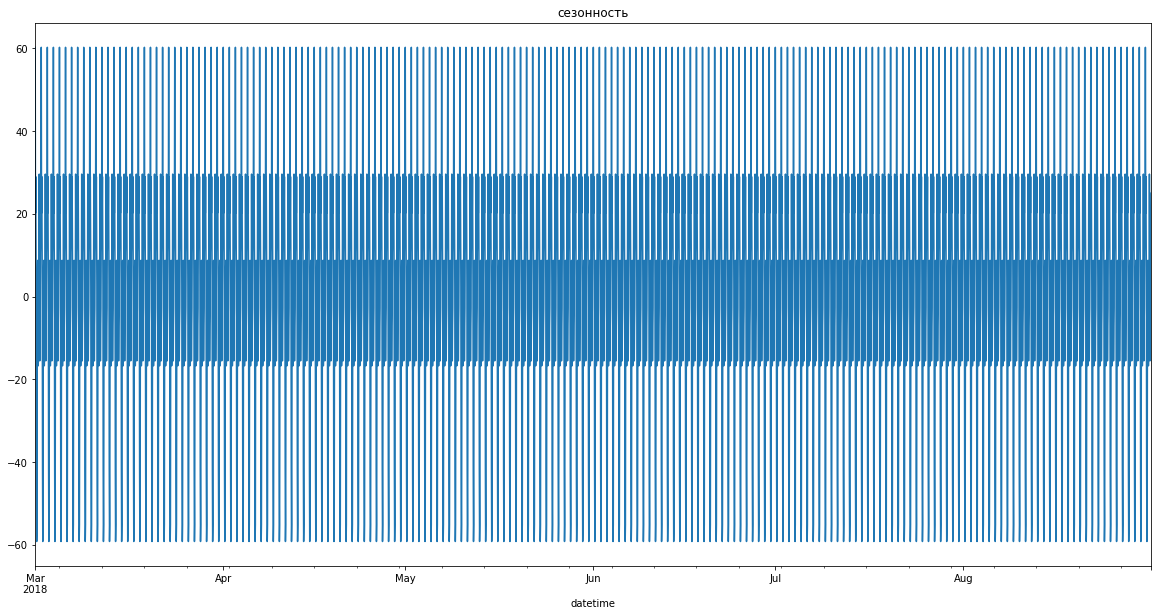

In [15]:
decomposed.seasonal.plot(figsize =(20,10), title='сезонность')

График тренда подтверждает рост количества заказов. А график сезонности скорее всего отражает сезонность в течение суток. Посмотрим на график сезонности за 3 суток.

In [16]:
decomposed_3 = seasonal_decompose(data['2018-03-01':'2018-03-3'])

<AxesSubplot:title={'center':'сезонность за 3 суток'}, xlabel='datetime'>

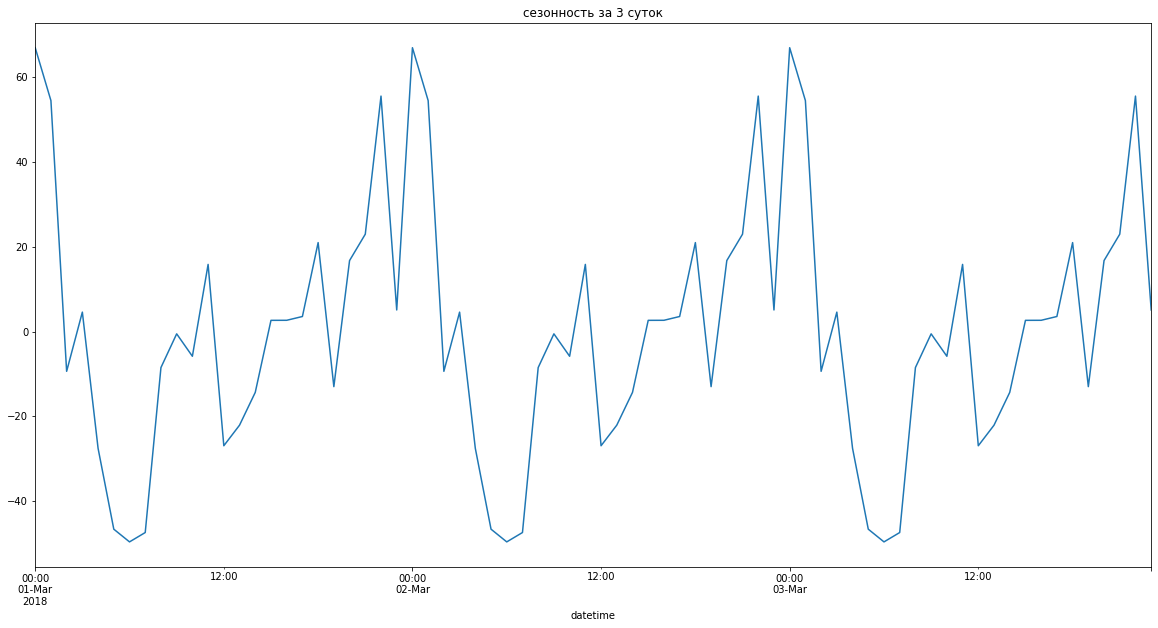

In [17]:
decomposed_3.seasonal.plot(figsize =(20,10), title='сезонность за 3 суток')

Можно утверждать что присутствует сезонность в течение суток.

Посмотрим есть ли сезонность по дням.

<AxesSubplot:title={'center':'сезонность по дням'}, xlabel='datetime'>

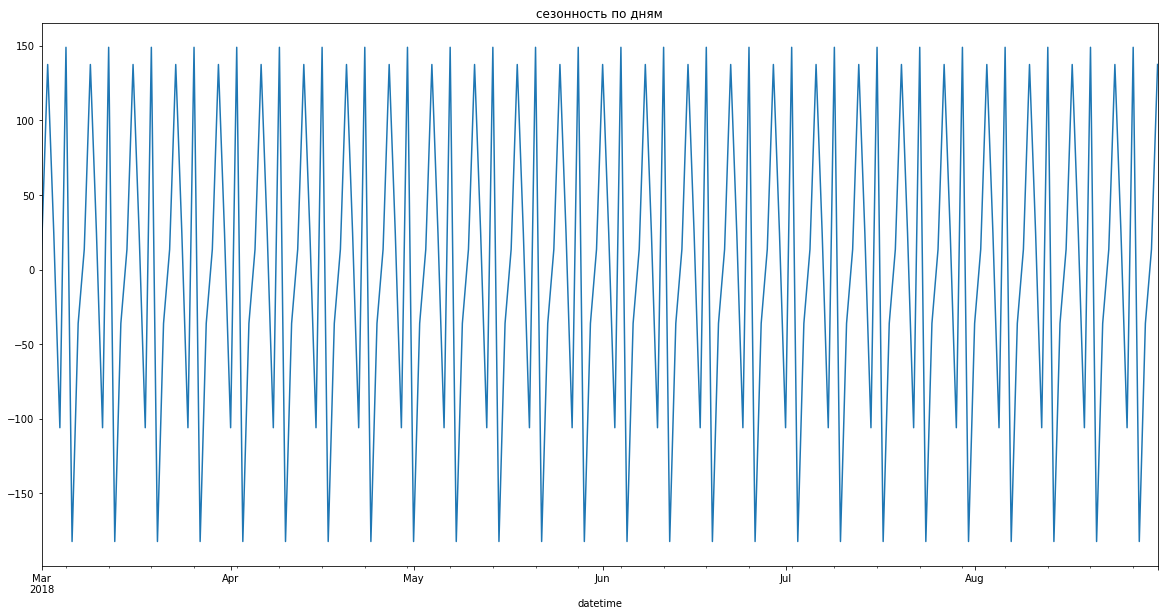

In [18]:
decomposed_d = seasonal_decompose(data.resample('1D').sum())
decomposed_d.seasonal.plot(figsize =(20,10), title='сезонность по дням')

Посмотрим подробнее, возьмём данные с 5 марта 2018 (это понедельник) по 1 апреля 2018 (это воскресенье). 

<AxesSubplot:title={'center':'сезонность за месяц'}, xlabel='datetime'>

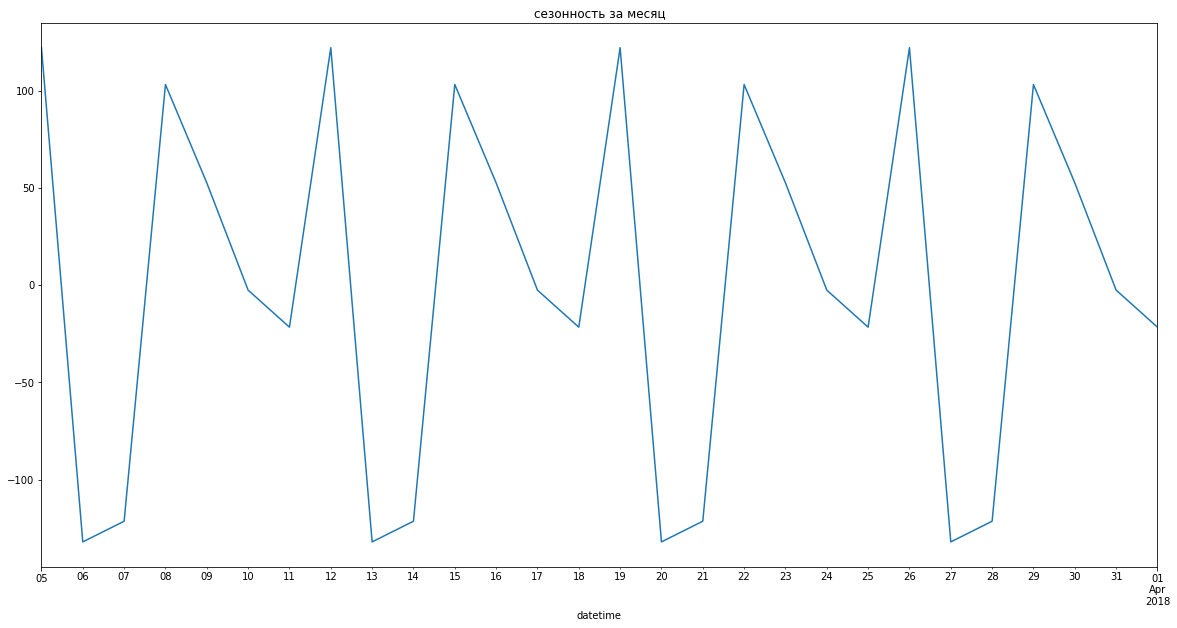

In [19]:
decomposed_05 = seasonal_decompose(data['2018-03-05':'2018-04-01'].resample('1D').sum())
decomposed_05.seasonal.plot(figsize =(20,10), title='сезонность за месяц')

Можно утверждать что существует сезонность в течение недели, если судить по графику наверху, то самый верхний пик приходится на понедельник, а самый нижний на вторник, возможно в понедельник люди тратят на такси все деньги, а потом экономят весь вторник :)

## Обучение

### Пояснение

Далее нам нужно создать модели. Мы будем создавать модели: Случайного леса, Линейной регрессии и CatBoostRegressor. 

Также мы проведём проверку адекватности моделей с помощью константной модели предыдущего значения ряда.

Для моделей из данных нам нужно будет заранее вытащить признаки (так как пока в данных один признак - количество заказов, и то он целевой): календарные признаки, отстающие значения и скользящее среднее.  

В дальнейшем будет выбрана лучшая модель с лучшими гиперпараметрами и проведётся её тестирование.

### Календарные признаки

Из календарных признаков мы возьмём час и день недели. Так как эти сезонности наблюдали на графиках.

In [20]:
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek
data.head(3)

,num_orders,hour,dayofweek
datetime,,,
2018-03-01 00:00:00,124,0,3
2018-03-01 01:00:00,85,1,3
2018-03-01 02:00:00,71,2,3


### Отстающие значения

Из-за того что существуют сезонности в течение суток и недели, мы создадим отстающие значения на одну неделю, т.е. до 168 лага включительно. Сделаем это через функцию. 

In [21]:
def make_features(data, max_lag):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

In [22]:
make_features(data, 168)
data = data.dropna()
data.head(3)

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,3,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-08 01:00:00,78,1,3,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-08 02:00:00,65,2,3,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0


In [23]:
data.shape

(4248, 171)

### Скользящее среднее

Скользящее среднее возьмем равное 12.

In [24]:
data['rolling_mean'] = data['num_orders'].shift().rolling(12).mean()
data = data.dropna()
data.head(3)

/tmp/ipykernel_31/1438301474.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rolling_mean'] = data['num_orders'].shift().rolling(12).mean()


,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 12:00:00,48,12,3,80.0,68.0,97.0,77.0,19.0,6.0,6.0,...,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,63.916667
2018-03-08 13:00:00,47,13,3,48.0,80.0,68.0,97.0,77.0,19.0,6.0,...,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,56.000000
2018-03-08 14:00:00,62,14,3,47.0,48.0,80.0,68.0,97.0,77.0,19.0,...,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,53.416667


In [25]:
data.shape

(4236, 172)

### Создадим выборки 

In [26]:
train_valid, test = train_test_split(data, shuffle=False, 
                               test_size=0.1)

train, valid = train_test_split(train_valid, shuffle=False, 
                               test_size=0.25)

print(train.shape, valid.shape, test.shape)

(2859, 172) (953, 172) (424, 172)


In [27]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Случайный лес

In [28]:
%%time
max_depth_list_f=[]
n_estimators_list_f=[]
RMSE_list_f=[]
for i in range(1,15):
    for e in range(1,15):
        model_f = RandomForestRegressor(random_state=12345,
                                                max_depth=i, 
                                                n_estimators=e)
        model_f.fit(features_train, target_train)
        predictions_valid_f = model_f.predict(features_valid)
        RMSE = mean_squared_error(target_valid, predictions_valid_f, squared=False)
        max_depth_list_f.append(i)
        n_estimators_list_f.append(e)
        RMSE_list_f.append(RMSE)
print('выполнено')

выполнено
CPU times: user 3min 20s, sys: 588 ms, total: 3min 20s
Wall time: 3min 21s


In [29]:
dict_f = {'RMSE': RMSE_list_f, 'max_depth': max_depth_list_f, 
        'n_estimators': n_estimators_list_f} 
df_f = pd.DataFrame(dict_f)
df_f = df_f.sort_values(by='RMSE')
df_f.head(5)

,RMSE,max_depth,n_estimators
59,29.114543,5,4
149,29.149092,11,10
177,29.162968,13,10
58,29.231145,5,3
163,29.248838,12,10


RMSE в норме.

### Линейная регрессия

In [30]:
%%time
model_L = LinearRegression()
model_L.fit(features_train, target_train)
predictions_valid_L = model_L.predict(features_valid)
RMSE = mean_squared_error(target_valid, predictions_valid_L,
                                          squared=False)
RMSE

CPU times: user 399 ms, sys: 1.32 s, total: 1.72 s
Wall time: 1.65 s


26.842404432184498

RMSE линейной регрессии не превышен.

### CatBoostRegressor

In [31]:
%%time
max_depth_list_C=[]
iterations_C=[]
RMSE_list_C=[]
for i in range(1,14):
    for e in range(1,14):
        model_C = CatBoostRegressor(max_depth=i,random_state=12345,
                         iterations=e)
        model_C.fit(features_train, target_train, verbose=False)
        predictions_valid_C = model_C.predict(features_valid)
        RMSE = mean_squared_error(target_valid, predictions_valid_C, squared=False)
        max_depth_list_C.append(i)
        iterations_C.append(e)
        RMSE_list_C.append(RMSE)
print('выполнено')

выполнено
CPU times: user 9min 37s, sys: 4.47 s, total: 9min 42s
Wall time: 10min 55s


In [32]:
dict_C = {'RMSE': RMSE_list_C, 'max_depth': max_depth_list_C, 
        'iterations': iterations_C} 
df_C = pd.DataFrame(dict_C)
df_C = df_C.sort_values(by='RMSE')
df_C.head(5)

,RMSE,max_depth,iterations
38,28.623714,3,13
37,28.679791,3,12
51,28.764205,4,13
36,28.818736,3,11
25,28.901262,2,13


RMSE CatBoostRegressor в норме. 

### Проверка на адекватность

Используем метод проверки на адекватность предыдущем значением ряда по всем данным.

In [33]:
pred = data['num_orders'].shift() 
pred = pred.dropna()
true = data['num_orders']
previous_result = mean_squared_error(true[1:], pred, squared=False)
print(f"RMSE при прогнозировании последним известным значением:", previous_result)

RMSE при прогнозировании последним известным значением: 39.31600249196314


Модель предыдущего значения ряда обладает самым высоким показателем RMSE.

Лучшей моделью стала модель Линейной регрессии. Её и проверим на тесте.

## Тестирование

In [34]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
RMSE_test = mean_squared_error(target_test, predictions_test,
                                          squared=False)
RMSE_test

35.32802838964674

Результат нас удовлетворяет.

## Вывод

Нашей целью было создать модель, которая будет предсказывать количество заказов такси на следующий час.

Данные предоставленные нам заказчиком не содержали пропусков и находились в хронологическом порядке.
В результате анализа мы обнаружили суточную и недельную сезонности в данных. Эти сезонности мы использовали для создания дополнительных признаков для наших моделей. 

На основе данных нами были созданы три модели: Случайного леса, Линейной регрессии и CatBoostRegressor. Все модели показали результат превосходящей константную модель проверки предыдущим значением ряда. 

Лучшей же моделью на этапе разработки оказалась модель Линейной регрессии. 

На тесте модель Линейной регрессии показала RMSE = 35. Рекомендуем эту модель заказчику.  